In [45]:
# load the autoreload extension
%load_ext autoreload
# set the level of reloading
%autoreload 2

from dfl_vrp.util import *
import torch
from dfl_vrp.heuristic.heuristic_solver import HeuristicSolver
from dfl_vrp.nce_model import NCEModel
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Load data

In [62]:
data = [parse_datafile(f'../data/capacity100/instances1000/nodes20/noise0.1/feat4/instance_{i}') for i in tqdm(range(5))]

TRAIN_PERCENTAGE, VALIDATION_PERCENTAGE, TEST_PERCENTAGE = 0.75, 0.05, 0.20
num_train, num_val, num_test = int(len(data) * TRAIN_PERCENTAGE), int(len(data) * VALIDATION_PERCENTAGE), int(len(data) * TEST_PERCENTAGE)
vrps_train, vrps_val, vrps_test = data[:num_train], data[num_train:num_train + num_val], data[num_train + num_val:]
print(f'Number of training instances: {len(vrps_train)}, validation instances: {len(vrps_val)}, test instances: {len(vrps_test)}')

100%|██████████| 5/5 [00:00<00:00, 40.69it/s]

Number of training instances: 3, validation instances: 0, test instances: 2


Actual objective: 0.4681999999999999


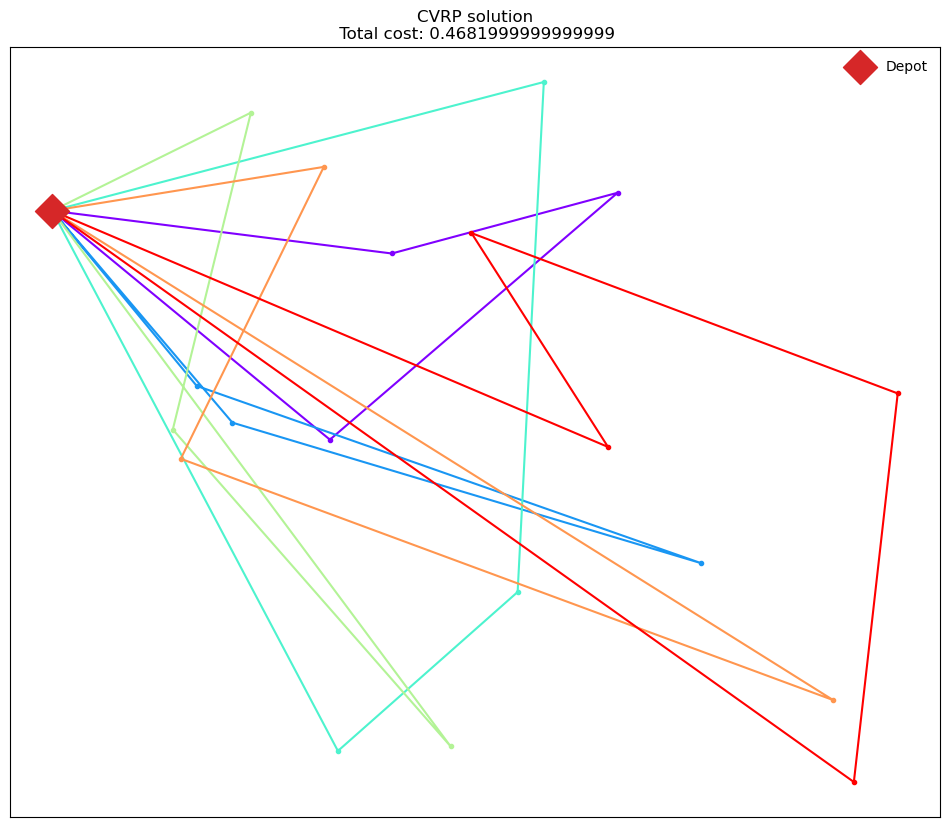

In [70]:
vrp = vrps_train[0]
solver = GurobiSolver(vrp, mip_gap=0, verbose=False, time_limit=5)
solver.solve()
print(f'Actual objective: {solver.get_actual_objective()}')
draw_solution(solver.vrp, solver.get_routes(), solver.get_actual_objective())

VRP actual objective: 0.4681999999999999


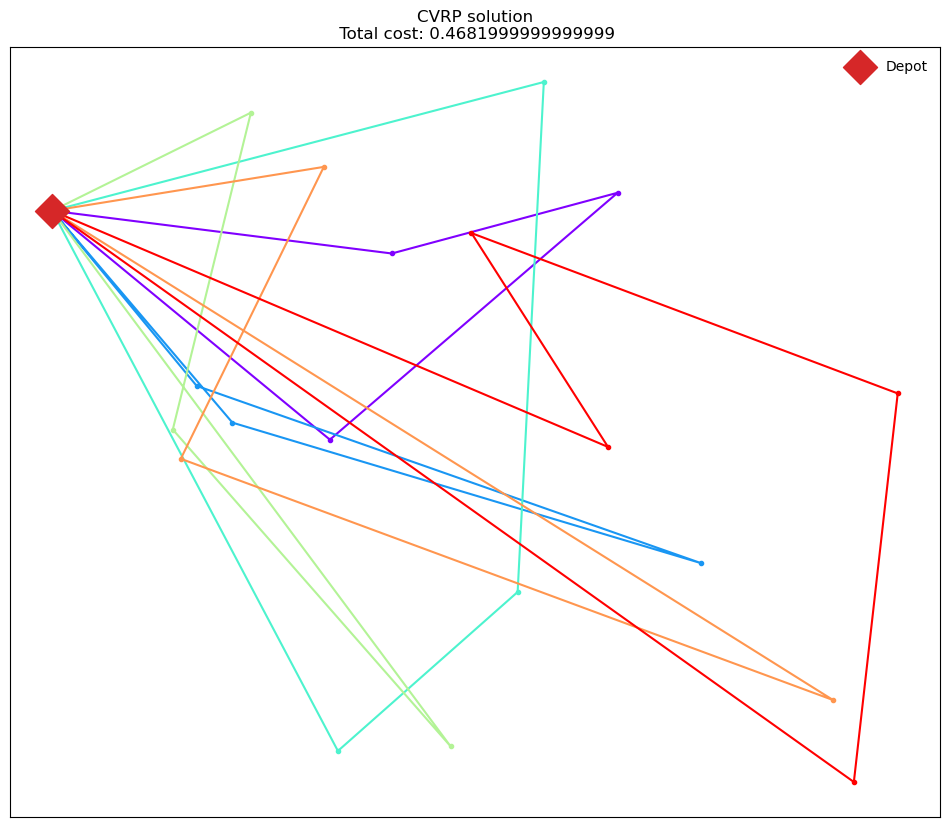

In [72]:
print(f'VRP actual objective: {vrp.actual_obj}')
draw_solution(vrp, vrp.actual_routes, vrp.actual_obj)

Heuristic objective: 0.48366


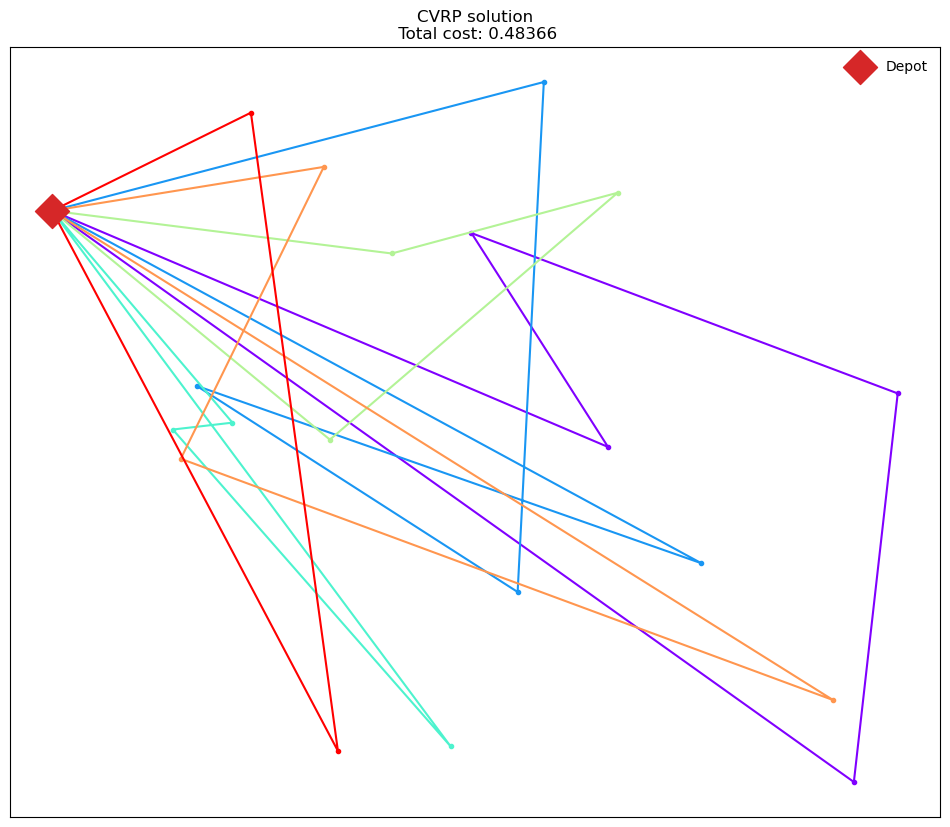

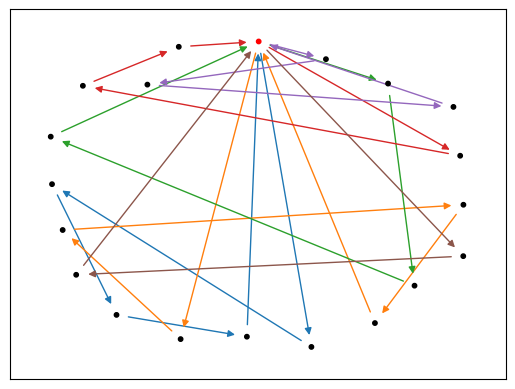

In [71]:
solver = HeuristicSolver(vrp, time_limit=2)
solver.solve()
print(f'Heuristic objective: {solver.get_actual_objective()}')
draw_solution(solver.vrp, solver.get_routes(), solver.get_actual_objective())
draw_solution1(solver.vrp, solver.get_routes())

# 1. 2-stage model

In [ ]:
from dfl_vrp.two_stage_model import TwoStageModel
model = TwoStageModel(vrps_train, vrps_val, vrps_test, lr=1e-3)
model.train(num_epochs=8)
model.test()
test_and_draw(model, vrps_test[0])
test(model, vrps_test, GurobiSolver)

Testing example instance VRP instance: ../data/capacity100/instances10000/nodes20/noise0.2/feat4/instance_1, predicted cost: 0.3044329881668091, actual cost: 0.19788
Drawing actual solution


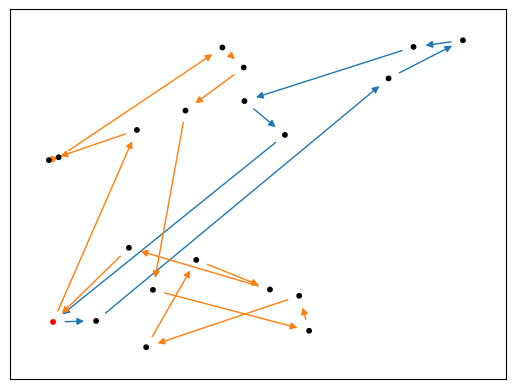

Drawing predicted solution


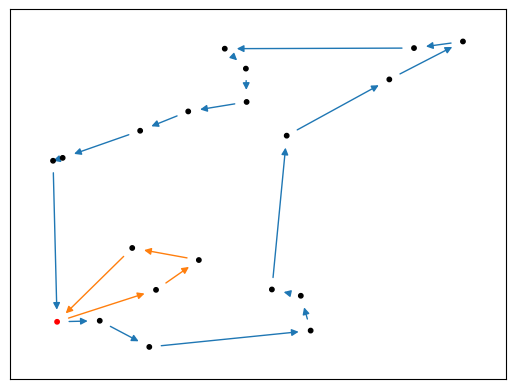

Actual edges (21): [0 -> 9, 0 -> 14, 1 -> 4, 2 -> 12, 3 -> 7, 4 -> 8, 5 -> 13, 6 -> 15, 7 -> 0, 8 -> 18, 9 -> 2, 10 -> 5, 11 -> 3, 12 -> 10, 13 -> 0, 14 -> 19, 15 -> 17, 16 -> 1, 17 -> 11, 18 -> 6, 19 -> 16]
Predicted edges (21): [0 -> 9, 0 -> 18, 1 -> 4, 2 -> 12, 3 -> 13, 4 -> 5, 5 -> 8, 6 -> 15, 7 -> 0, 8 -> 14, 9 -> 17, 10 -> 1, 11 -> 7, 12 -> 10, 13 -> 2, 14 -> 16, 15 -> 3, 16 -> 19, 17 -> 6, 18 -> 11, 19 -> 0]
Correct edges (6): {6 -> 15, 12 -> 10, 7 -> 0, 0 -> 9, 1 -> 4, 2 -> 12}


In [23]:
test(model, vrps_test, GurobiSolver)

In [25]:
from dfl_vrp.spo_model import SPOModel
spo_model = SPOModel(vrps_train, vrps_val, vrps_test, solver_class=GurobiSolver, lr=1e-3, solve_prob=1, weight_decay=0)
spo_model.train(epochs=8, verbose=False, test_every=1)

9it [00:00, 40.34it/s]


Interrupt request received


7500it [10:48, 11.56it/s]


Epoch 1 / 8 done, mean loss: 112.12752979736328, validation loss: 107.90401141357422


100%|██████████| 2000/2000 [01:47<00:00, 18.59it/s]


Accuracy: 0.08026980519480541, cost comparison: 3.6838160773190936, regret: 2.755779880368943


7500it [15:26,  8.10it/s]


Epoch 2 / 8 done, mean loss: 79.75860364176432, validation loss: 119.444599609375


100%|██████████| 2000/2000 [01:57<00:00, 17.07it/s]


Accuracy: 0.08894242424242486, cost comparison: 3.5458184047894363, regret: 2.6140819403689375


1430it [01:48, 13.46it/s]


Interrupt request received

Interrupt request received


1430it [01:48, 13.21it/s]

KeyboardInterrupt



Actual objective: 1.8465699999999998


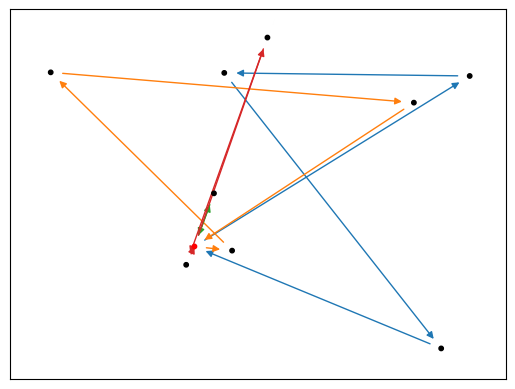

Predicted objective: 2.60664


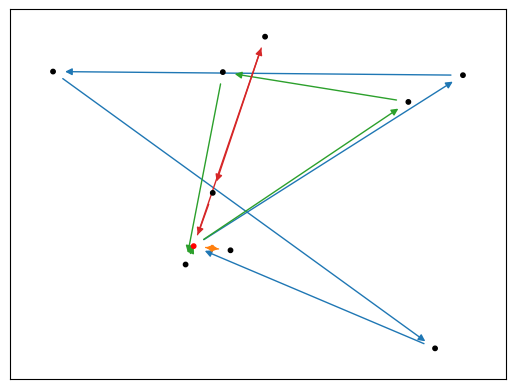

In [11]:
spo_model.cost_model.eval()
vrp = vrps_train[1]
# vrp = vrps_test[0]
costs = spo_model.cost_model(torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32))
# set the predicted edge costs
for i, edge in enumerate(vrp.edges):
    edge.predicted_cost = costs[i].detach().item()

solver = GurobiSolver(vrp)
solver.solve()
print(f'Actual objective: {solver.get_actual_objective()}')
draw_solution(solver)

solver = GurobiSolver(vrp, mode=SolverMode.PRED_COST)
solver.solve()
print(f'Predicted objective: {solver.get_actual_objective()}')
draw_solution(solver)